In [ ]:
import pandas as pd
import numpy as np

import os
import sys
import random

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
#from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import kagglehub

# "{ latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [ ]:
import librosa
import numpy as np
import os

import librosa
import numpy as np
import matplotlib.pyplot as plt

def extract_features(file_path, max_len=862, n_mfcc=40, sr=22050, plot=False):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=sr)

        # 1 Silence Removal using Zero Crossing Rate (ZCR)
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        threshold = 0.02  # Adjust based on dataset
        mask = zcr > threshold
        if mask.any():
            frames = librosa.frames_to_samples(np.where(mask)[0])
            if len(frames) > 1:
                y = y[frames[0]:frames[-1]]

        # 2️Pre-emphasis
        y_preemph = librosa.effects.preemphasis(y)

        # 3️Normalization
        y_norm = y_preemph / np.max(np.abs(y_preemph))  # Avoid division by zero

        # 4️Extract MFCCs
        mfcc = librosa.feature.mfcc(y=y_norm, sr=sr, n_mfcc=n_mfcc)
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]

        # Optional Plotting
        if plot:
            S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
            S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(y_preemph)), ref=np.max)
            S_norm = librosa.amplitude_to_db(np.abs(librosa.stft(y_norm)), ref=np.max)

            fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(10, 8))
            librosa.display.specshow(S_orig, y_axis='log', x_axis='time', ax=ax[0])
            ax[0].set(title='Original signal')
            ax[0].label_outer()
            librosa.display.specshow(S_preemph, y_axis='log', x_axis='time', ax=ax[1])
            ax[1].set(title='Pre-emphasized signal')
            ax[1].label_outer()
            img = librosa.display.specshow(S_norm, y_axis='log', x_axis='time', ax=ax[2])
            ax[2].set(title='Normalized signal')
            fig.colorbar(img, ax=ax, format="%+2.f dB")
            plt.show()

        return mfcc.T  # Shape: (timesteps, features)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# 🔥 Load all .wav files and extract features
X, y = [], []
label_map = {'01': 0, '02': 1, '03': 2, '04': 3, '05': 4, '06': 5, '07': 6, '08': 7}  # RAVDESS emotion codes

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            features = extract_features(file_path)
            if features is not None:
                # Extract label (ensure filename format is correct)
                emotion_code = file.split('-')[2]
                label = label_map.get(emotion_code)
                if label is not None:
                    X.append(features)
                    y.append(label)
                else:
                    print(f"Unknown label in file: {file}")

X = np.array(X)
y = np.array(y)

print(f"Feature shape: {X.shape}")  # (samples, timesteps, features)
print(f"Labels shape: {y.shape}")   # (samples,)


Feature shape: (2880, 862, 40)
Labels shape: (2880,)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.regularizers import l2

sequence_len = X.shape[1]     # Time steps (e.g., MFCC length)
feature_dim = X.shape[2]      # Feature dimension (e.g., MFCC coefficients)
num_classes = 8               # Emotions

inputs = Input(shape=(sequence_len, feature_dim))

# Step 1: CNN with Stronger Regularization
x = Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.4)(x)  # Increased dropout

x = Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.4)(x)

# Step 2: BiLSTM with Dropout and Recurrent Dropout
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)

# Step 3: Transformer Encoder Block (with Dropout)
attn_output = MultiHeadAttention(num_heads=4, key_dim=128, dropout=0.3)(x, x)
attn_output = Add()([x, attn_output])
attn_output = LayerNormalization()(attn_output)

# Step 4: Global Pooling and Dense Layers with Stronger Regularization
x = GlobalAveragePooling1D()(attn_output)
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)  # Increased dropout
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 862, 40)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 862, 64)   │      7,744 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 862, 64)   │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 431, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 431, 64)   │          0 │ max_pooling1d_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 431, 128)  │     24,704 │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 431, 128)  │        512 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 215, 128)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 215, 128)  │          0 │ max_pooling1d_11… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 215, 256)  │    263,168 │ dropout_36[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 215, 256)  │    526,080 │ bidirectional_5[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 215, 256)  │          0 │ bidirectional_5[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 215, 256)  │        512 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 128)       │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 8)         │      1,032 │ dropout_38[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 856,904 (3.27 MB)

 Trainable params: 856,520 (3.27 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_split=0.2)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 998ms/step - accuracy: 0.1231 - loss: 2.2740 - val_accuracy: 0.1272 - val_loss: 2.1130
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 980ms/step - accuracy: 0.1462 - loss: 2.1091 - val_accuracy: 0.1272 - val_loss: 2.1026
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 966ms/step - accuracy: 0.1261 - loss: 2.1017 - val_accuracy: 0.1696 - val_loss: 2.0608
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 969ms/step - accuracy: 0.1730 - loss: 2.0410 - val_accuracy: 0.2274 - val_loss: 1.8838
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 975ms/step - accuracy: 0.2077 - loss: 1.9992 - val_accuracy: 0.2620 - val_loss: 1.8172
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 969ms/step - accuracy: 0.2390 - loss: 1.9099 - val_accuracy: 0.2871 - val_loss: 1.7713
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 973ms/step - accuracy: 0.2467 - loss: 1.8561 - val_accuracy: 0.3121 - val_loss: 1.7811
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 961ms/step - accuracy: 0.2581 - loss: 1.8171 - val_accu

In [ ]:
accuracy = model.evaluate(x_val,y_val)[1]*100

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7543 - loss: 0.8012


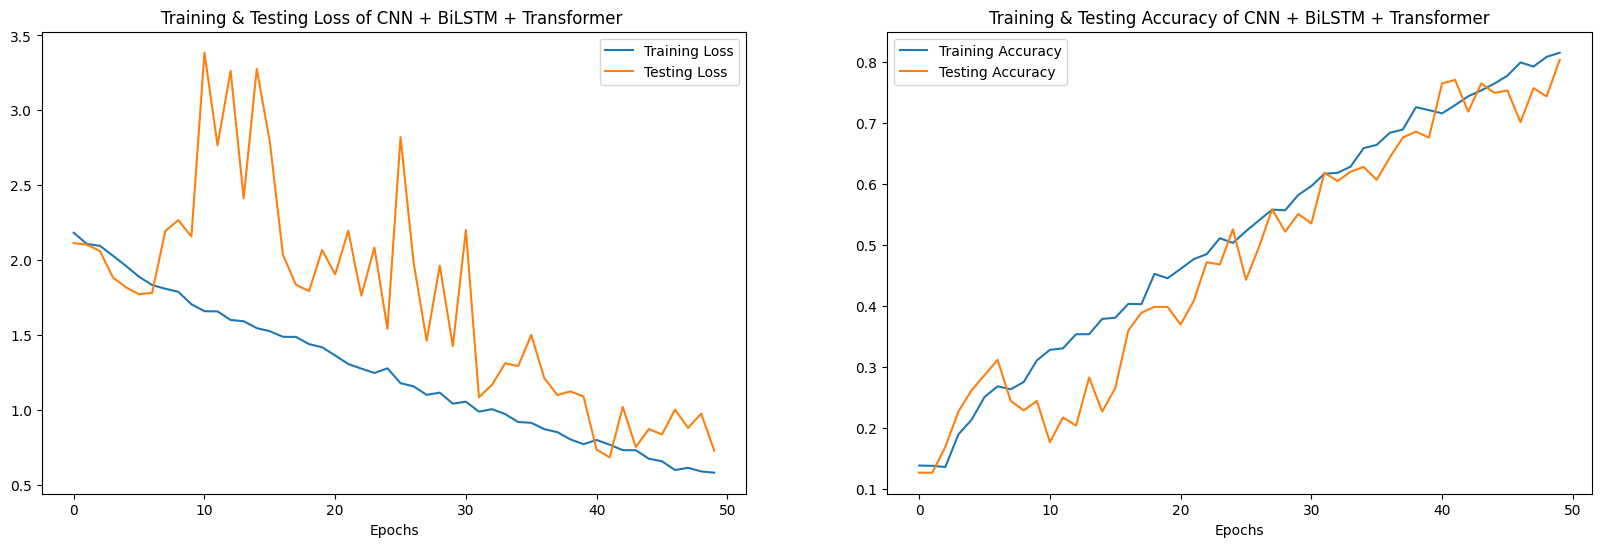

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss of CNN + BiLSTM + Transformer ')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy of CNN + BiLSTM + Transformer')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert probabilities to predicted class indices
y_pred = np.argmax(pred_val, axis=1)


In [ ]:
# Original label map
label_map = {'01': 0, '02': 1, '03': 2, '04': 3, '05': 4, '06': 5, '07': 6, '08': 7}
inverse_label_map = {v: k for k, v in label_map.items()}

# Emotion names
emotions_all = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [ ]:
# Convert predicted and true labels from indices to codes, then to emotion names
y_pred_codes = [inverse_label_map[i] for i in y_pred]
y_val_codes = [inverse_label_map[i] for i in y_val]
y_pred_emotions = [emotions_all[code] for code in y_pred_codes]
y_val_emotions = [emotions_all[code] for code in y_val_codes]

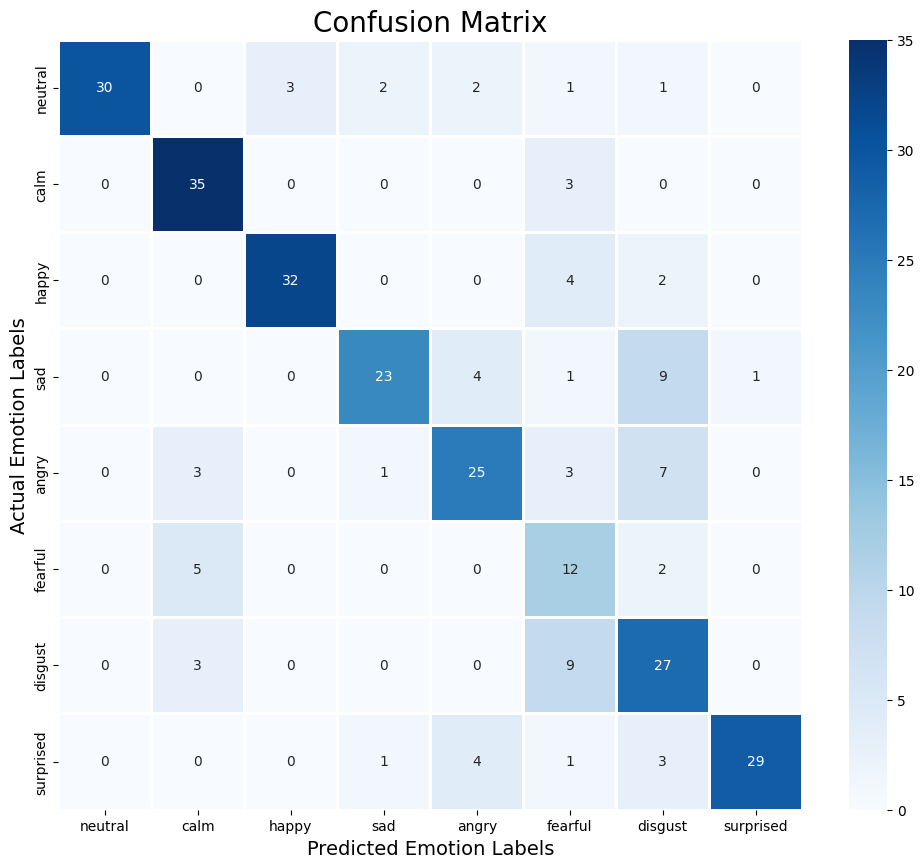

In [ ]:

# Compute confusion matrix
cm = confusion_matrix(y_val_emotions, y_pred_emotions)

# Get sorted list of emotion names
labels_sorted = [emotions_all[code] for code in sorted(label_map.keys())]

# Convert to DataFrame for seaborn heatmap
cm_df = pd.DataFrame(cm, index=labels_sorted, columns=labels_sorted)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='white')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Emotion Labels', size=14)
plt.ylabel('Actual Emotion Labels', size=14)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.63      0.35      0.45        34
           1       0.92      0.76      0.83        46
           2       0.64      0.71      0.68        35
           3       0.69      0.53      0.60        51
           4       0.77      1.00      0.87        30
           5       0.61      0.85      0.71        27
           6       0.84      0.91      0.88        35
           7       0.76      0.97      0.85        30

    accuracy                           0.74       288
   macro avg       0.73      0.76      0.73       288
weighted avg       0.74      0.74      0.73       288

